In [71]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from vehicle_detection_helper import *

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Train a car/not-car classifier

In [142]:
# Read in cars and notcars
images_path = './data/input/'

cars = glob.glob(images_path + 'cars_jpg/*.jpg')
notcars = glob.glob(images_path + 'not-cars_jpg/*.jpg')

# Reduce the sample size for rapid prototyping
# Comment out this portion to use entire data set
#sample_size = 600
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

print('No. of cars:    {}'.format(len(cars)))
print('No. of notcars: {}'.format(len(notcars)))

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 25  # HOG orientations
pix_per_cell = 9 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [350, 675] # Min and max in y to search in slide_window()

No. of cars:    16741
No. of notcars: 17036


In [143]:
car_features = extract_features(cars,
                                color_space=color_space,
                                spatial_size=spatial_size,
                                hist_bins=hist_bins,
                                orient=orient,
                                pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel,
                                spatial_feat=spatial_feat,
                                hist_feat=hist_feat,
                                hog_feat=hog_feat)

notcar_features = extract_features(notcars,
                                   color_space=color_space,
                                   spatial_size=spatial_size,
                                   hist_bins=hist_bins,
                                   orient=orient,
                                   pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel,
                                   spatial_feat=spatial_feat,
                                   hist_feat=hist_feat,
                                   hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')

print('Feature vector length:', len(X_train[0]))



/home/alau/anaconda3/envs/dl_tf_gpu_1_2/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 25 orientations 9 pixels per cell and 2 cells per block
Feature vector length: 11616


In [144]:
# Train the Classifier
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

95.36 Seconds to train SVC...
Test Accuracy of SVC =  0.9941


In [146]:
# Check the prediction time for a single sample
t = time.time()
print('Prediction on Test image ', svc.predict([X_test[2]]))
t2 = time.time()
print(round(t2-t,4), 'Seconds for a single prediction.')

Prediction on Test image  [ 1.]
0.0039 Seconds for a single prediction.


### Detect cars in test image

/home/alau/anaconda3/envs/dl_tf_gpu_1_2/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Execution time: 1.2508 seconds


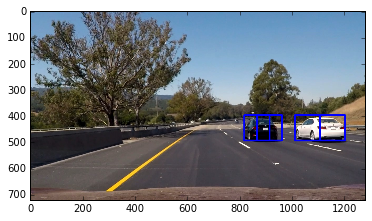

In [147]:
# Using sliding window, extracting hog features per window
test_img = mpimg.imread('./test_images/test6.jpg')
draw_image = np.copy(test_img)

t = time.time()

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(test_img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(test_img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

t2 = time.time()
print('Execution time: {} seconds'.format(round(t2-t, 4)))

plt.imshow(window_img)

### Faster implementation 

Define a single function that can extract features using hog sub-sampling and make predictions

/home/alau/anaconda3/envs/dl_tf_gpu_1_2/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Execution time: 1.7097 seconds


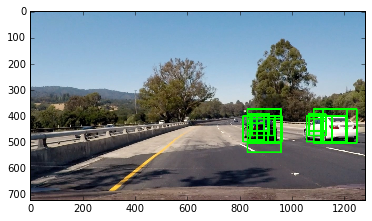

In [155]:
ystart = 375
ystop = 675
scales = [1.0, 1.5, 2.0]
test_img = mpimg.imread('./test_images/test4.jpg')

box_list = []
t = time.time()
for scale in scales:
    boxes = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list.extend(boxes)
t2 = time.time()

out_img = draw_boxes(test_img, box_list)
print("Execution time: {} seconds".format(round(t2-t, 4)))
plt.imshow(out_img)

### Aggregate positive multiple-detection windows and eliminate false positives using heat maps

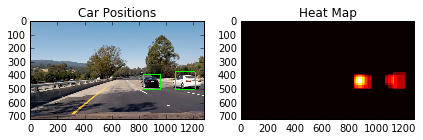

In [156]:
image = test_img
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122), 
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()